## Objective
Build a predictive model that estimatest he probability of various match outcomes (win, draw, loss) for each team.

### Application
To be used in a sports betting scenario by comparing model's predicted probabilities with betting odds, I can potentially spot value bets

In [3]:
# libraries
%pip install scikit-learn
import pandas as pd
pd.set_option('display.max_columns', 55)
from sklearn.preprocessing import StandardScaler

Note: you may need to restart the kernel to use updated packages.


In [4]:
df = pd.read_parquet('games.parquet')
print(df.head())

                      home                  away        date  gh  ga  \
0         Bolton Wanderers          Derby County  1888-09-08   3   6   
1               Everton FC         Accrington FC  1888-09-08   2   1   
2        Preston North End            Burnley FC  1888-09-08   5   2   
3               Stoke City  West Bromwich Albion  1888-09-08   0   2   
4  Wolverhampton Wanderers           Aston Villa  1888-09-08   1   1   

  full_time competition                         home_ident  \
0         F     england         Bolton Wanderers (England)   
1         F     england               Everton FC (England)   
2         F     england        Preston North End (England)   
3         F     england               Stoke City (England)   
4         F     england  Wolverhampton Wanderers (England)   

                       away_ident home_country away_country home_code  \
0          Derby County (England)      england      england       ENG   
1         Accrington FC (England)      england  

In [5]:
# More examindation of the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1237935 entries, 0 to 1237934
Data columns (total 17 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   home            1237575 non-null  object
 1   away            1237568 non-null  object
 2   date            1237935 non-null  object
 3   gh              1237935 non-null  int32 
 4   ga              1237935 non-null  int32 
 5   full_time       1237935 non-null  object
 6   competition     1229433 non-null  object
 7   home_ident      1237935 non-null  object
 8   away_ident      1237935 non-null  object
 9   home_country    1237935 non-null  object
 10  away_country    1237935 non-null  object
 11  home_code       1237935 non-null  object
 12  away_code       1237935 non-null  object
 13  home_continent  1237935 non-null  object
 14  away_continent  1237935 non-null  object
 15  continent       1237935 non-null  object
 16  level           1237935 non-null  object
dtypes: int32

In [6]:
print(df.describe())

                 gh            ga
count  1.237935e+06  1.237935e+06
mean   1.611417e+00  1.150681e+00
std    1.443697e+00  1.216481e+00
min    0.000000e+00  0.000000e+00
25%    1.000000e+00  0.000000e+00
50%    1.000000e+00  1.000000e+00
75%    2.000000e+00  2.000000e+00
max    2.500000e+01  2.400000e+01


In [7]:
print(df.columns)

Index(['home', 'away', 'date', 'gh', 'ga', 'full_time', 'competition',
       'home_ident', 'away_ident', 'home_country', 'away_country', 'home_code',
       'away_code', 'home_continent', 'away_continent', 'continent', 'level'],
      dtype='object')


In [8]:
# checking for missing values in each column
print(df.isnull().sum())

home               360
away               367
date                 0
gh                   0
ga                   0
full_time            0
competition       8502
home_ident           0
away_ident           0
home_country         0
away_country         0
home_code            0
away_code            0
home_continent       0
away_continent       0
continent            0
level                0
dtype: int64


In [9]:
#  Drop rows with missing critical values
df = df.dropna(subset=['home', 'away', 'competition'])

In [10]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Filter out all matches before January 1, 2000
df = df[df['date'] >= '2000-01-01']
print("Earliest date in dataset:", df['date'].min())
print(df[['date']].head())

Earliest date in dataset: 2000-01-01 00:00:00
             date
468088 2000-01-01
468089 2000-01-01
468090 2000-01-01
468091 2000-01-01
468092 2000-01-01


In [11]:
# Check the unique values in the 'competition' column in order to drop non-europe competitions
unique_competitions = df['competition'].unique()
print("length of unique competitions in  dataset:", len(unique_competitions))

# Define the top five domestic league countries
top_leagues = ['england', 'spain', 'italy', 'germany', 'france']
uefa_comp = ['UEFA EL', 'UEFA CL', 'UEFA CONF L']


# condition to check for league matches
condition_domestic = df['competition'].str.lower().isin(top_leagues)

# condition to check for uefa competitions
condition_uefa = df['competition'].str.upper().isin(uefa_comp)

df_filtered = df[condition_domestic | condition_uefa]
df_filtered = df_filtered.sort_values(by='date')

# Print some information to verify filtering
print("Total matches before filtering:", len(df))
print("Total matches after filtering:", len(df_filtered))
print("Unique competitions in the filtered dataset:")
print(df_filtered['competition'].unique())



length of unique competitions in  dataset: 224
Total matches before filtering: 765561
Total matches after filtering: 58604
Unique competitions in the filtered dataset:
['england' 'spain' 'italy' 'france' 'germany' 'UEFA EL' 'UEFA CL'
 'UEFA CONF L']


In [12]:
df_filtered.tail()

,home,away,date,gh,ga,full_time,competition,home_ident,away_ident,home_country,away_country,home_code,away_code,home_continent,away_continent,continent,level
1237803,Luton Town,Chelsea FC,2023-12-30,2,3,F,england,Luton Town (England),Chelsea FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national
1237808,Nottingham Forest,Manchester United,2023-12-30,2,1,F,england,Nottingham Forest (England),Manchester United (England),england,england,ENG,ENG,Europe,Europe,Europe,national
1237827,Juventus,As Roma,2023-12-30,1,0,F,italy,Juventus (Italy),As Roma (Italy),italy,italy,IT,IT,Europe,Europe,Europe,national
1237893,Fulham FC,Arsenal FC,2023-12-31,2,1,F,england,Fulham FC (England),Arsenal FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national
1237894,Tottenham Hotspur,Afc Bournemouth,2023-12-31,3,1,F,england,Tottenham Hotspur (England),Afc Bournemouth (England),england,england,ENG,ENG,Europe,Europe,Europe,national


## Feature Engineering

In [13]:
def get_result(row):
    if row['gh'] > row['ga']:
        return 'home_win'
    elif row['gh'] < row['ga']:
        return 'away_win'
    else:
        return 'draw'

df_filtered['match_result'] = df_filtered.apply(get_result, axis=1)
df_filtered['goal_diff'] = df_filtered['gh'] - df_filtered['ga'] # tells the dominance of a team in a game. negatives in the direction of the opposing team
df_filtered['total_goals'] = df_filtered['gh'] + df_filtered['ga']

In [14]:
df_filtered.tail(10)

,home,away,date,gh,ga,full_time,competition,home_ident,away_ident,home_country,away_country,home_code,away_code,home_continent,away_continent,continent,level,match_result,goal_diff,total_goals
1237822,Atalanta,US Lecce,2023-12-30,1,0,F,italy,Atalanta (Italy),US Lecce (Italy),italy,italy,IT,IT,Europe,Europe,Europe,national,home_win,1,1
1237806,Manchester City,Sheffield United,2023-12-30,2,0,F,england,Manchester City (England),Sheffield United (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,2,2
1237807,Wolverhampton Wanderers,Everton FC,2023-12-30,3,0,F,england,Wolverhampton Wanderers (England),Everton FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,3,3
1237805,Crystal Palace,Brentford FC,2023-12-30,3,1,F,england,Crystal Palace (England),Brentford FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,2,4
1237804,Aston Villa,Burnley FC,2023-12-30,3,2,F,england,Aston Villa (England),Burnley FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,1,5
1237803,Luton Town,Chelsea FC,2023-12-30,2,3,F,england,Luton Town (England),Chelsea FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national,away_win,-1,5
1237808,Nottingham Forest,Manchester United,2023-12-30,2,1,F,england,Nottingham Forest (England),Manchester United (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,1,3
1237827,Juventus,As Roma,2023-12-30,1,0,F,italy,Juventus (Italy),As Roma (Italy),italy,italy,IT,IT,Europe,Europe,Europe,national,home_win,1,1
1237893,Fulham FC,Arsenal FC,2023-12-31,2,1,F,england,Fulham FC (England),Arsenal FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,1,3
1237894,Tottenham Hotspur,Afc Bournemouth,2023-12-31,3,1,F,england,Tottenham Hotspur (England),Afc Bournemouth (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,2,4


#### Creating Season Identifier plus determining rest days for each team

In [15]:
# Extract year, month, and day of week from the date
df_filtered['year'] = df_filtered['date'].dt.year
df_filtered['month'] = df_filtered['date'].dt.month
df_filtered['day_of_week'] = df_filtered['date'].dt.dayofweek  # 0=Monday, 6=Sunday

print(df_filtered[['date', 'year', 'month', 'day_of_week']].head())

             date  year  month  day_of_week
468120 2000-01-03  2000      1            0
468121 2000-01-03  2000      1            0
468122 2000-01-03  2000      1            0
468123 2000-01-03  2000      1            0
468124 2000-01-03  2000      1            0


In [16]:
# since I am using europe's standard for a season. I will probably drop other leagues from the data set and focus on europe football
def get_season(row):
    year = row['year']
    month = row['month']
    # Adjust the cutoff as needed; here we assume season starts in August
    if month >= 8:
        season_start = year
        season_end = year + 1
    else:
        season_start = year - 1
        season_end = year
    return f"{season_start}-{season_end}"

# Create a new 'season' column using the helper function
df_filtered['season'] = df_filtered.apply(get_season, axis=1)

# Check the results
print(df_filtered[['date', 'year', 'month', 'season']].tail(10))

              date  year  month     season
1237822 2023-12-30  2023     12  2023-2024
1237806 2023-12-30  2023     12  2023-2024
1237807 2023-12-30  2023     12  2023-2024
1237805 2023-12-30  2023     12  2023-2024
1237804 2023-12-30  2023     12  2023-2024
1237803 2023-12-30  2023     12  2023-2024
1237808 2023-12-30  2023     12  2023-2024
1237827 2023-12-30  2023     12  2023-2024
1237893 2023-12-31  2023     12  2023-2024
1237894 2023-12-31  2023     12  2023-2024


In [17]:
# Calculating rest days.


# For home teams: calculate days since the previous home match for each home team
df_filtered['home_rest_days'] = df_filtered.groupby('home_ident')['date'].diff().dt.days

# For away teams: calculate days since the previous away match for each away team
df_filtered['away_rest_days'] = df_filtered.groupby('away_ident')['date'].diff().dt.days

# Define a function to assign points based on the match result for a given location
def assign_points(row, location='home'):
    if location == 'home':
        if row['match_result'] == 'home_win':
            return 3
        elif row['match_result'] == 'draw':
            return 1
        else:
            return 0
    else:  # away
        if row['match_result'] == 'away_win':
            return 3
        elif row['match_result'] == 'draw':
            return 1
        else:
            return 0

# Create points columns for home and away
df_filtered['home_points'] = df_filtered.apply(lambda row: assign_points(row, location='home'), axis=1)
df_filtered['away_points'] = df_filtered.apply(lambda row: assign_points(row, location='away'), axis=1)

# Compute rolling form: average points over the last 5 matches for each team
df_filtered['home_form'] = df_filtered.groupby('home_ident')['home_points']\
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
df_filtered['away_form'] = df_filtered.groupby('away_ident')['away_points']\
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())


# Inspect the new rest day columns
print(df_filtered[['home', 'date', 'home_rest_days']].tail(10))
print(df_filtered[['away', 'date', 'away_rest_days']].tail(10))

                            home       date  home_rest_days
1237822                 Atalanta 2023-12-30            12.0
1237806          Manchester City 2023-12-30            14.0
1237807  Wolverhampton Wanderers 2023-12-30             6.0
1237805           Crystal Palace 2023-12-30             9.0
1237804              Aston Villa 2023-12-30             8.0
1237803               Luton Town 2023-12-30             7.0
1237808        Nottingham Forest 2023-12-30             7.0
1237827                 Juventus 2023-12-30            22.0
1237893                Fulham FC 2023-12-31             8.0
1237894        Tottenham Hotspur 2023-12-31             8.0
                      away       date  away_rest_days
1237822           US Lecce 2023-12-30             7.0
1237806   Sheffield United 2023-12-30             8.0
1237807         Everton FC 2023-12-30             7.0
1237805       Brentford FC 2023-12-30            21.0
1237804         Burnley FC 2023-12-30             7.0
1237803         

In [18]:
df_filtered.tail()

,home,away,date,gh,ga,full_time,competition,home_ident,away_ident,home_country,away_country,home_code,away_code,home_continent,away_continent,continent,level,match_result,goal_diff,total_goals,year,month,day_of_week,season,home_rest_days,away_rest_days,home_points,away_points,home_form,away_form
1237803,Luton Town,Chelsea FC,2023-12-30,2,3,F,england,Luton Town (England),Chelsea FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national,away_win,-1,5,2023,12,5,2023-2024,7.0,6.0,0,3,1.4,0.6
1237808,Nottingham Forest,Manchester United,2023-12-30,2,1,F,england,Nottingham Forest (England),Manchester United (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,1,3,2023,12,5,2023-2024,7.0,7.0,3,0,0.6,1.0
1237827,Juventus,As Roma,2023-12-30,1,0,F,italy,Juventus (Italy),As Roma (Italy),italy,italy,IT,IT,Europe,Europe,Europe,national,home_win,1,1,2023,12,5,2023-2024,22.0,13.0,3,0,2.6,1.0
1237893,Fulham FC,Arsenal FC,2023-12-31,2,1,F,england,Fulham FC (England),Arsenal FC (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,1,3,2023,12,6,2023-2024,8.0,8.0,3,0,1.8,1.6
1237894,Tottenham Hotspur,Afc Bournemouth,2023-12-31,3,1,F,england,Tottenham Hotspur (England),Afc Bournemouth (England),england,england,ENG,ENG,Europe,Europe,Europe,national,home_win,2,4,2023,12,6,2023-2024,8.0,8.0,3,0,1.2,2.4


Seperating national from international level

In [19]:
# competition encoding
df_encoded = pd.get_dummies(df_filtered, columns=['competition'], prefix='comp')

# level of competition
df_encoded = pd.get_dummies(df_encoded, columns=['level'], prefix='level')

# domestic vs international
# Create a binary feature: 1 if the match is domestic (i.e., home_country equals away_country), 0 if international.
df_encoded['domestic'] = (df_encoded['home_country'] == df_encoded['away_country']).astype(int)

# One-hot encode the home and away continents.
df_encoded = pd.get_dummies(df_encoded, columns=['home_continent'], prefix='home_cont')
df_encoded = pd.get_dummies(df_encoded, columns=['away_continent'], prefix='away_cont')



print(df_encoded.sample(n=10))

                        home                  away       date  gh  ga  \
695856   Deportivo La Coruna        Sporting Gijon 2008-10-26   0   3   
1150434     As Saint Etienne              OGC Nice 2021-09-25   0   3   
884897             Hull City  West Bromwich Albion 2014-03-22   2   0   
649606             Gimnastic         Villarreal CF 2007-04-29   0   3   
1119667            Lille OSC            FC Lorient 2020-11-22   4   0   
848838    Espanyol Barcelona         Real Sociedad 2013-03-31   2   2   
733210       Montpellier HSC            Le Mans FC 2009-12-05   2   1   
689624            MSk Zilina        Slovan Liberec 2008-08-28   2   1   
652164              Atalanta                 Inter 2007-05-20   1   1   
627875             FC Nantes          Estac Troyes 2006-08-19   1   1   

        full_time                   home_ident  \
695856          F  Deportivo La Coruna (Spain)   
1150434         F    As Saint Etienne (France)   
884897          F          Hull City (England)

In [20]:
# copy of df_filtered
df_perf = df_filtered.copy()
# I have like four data frames now lol

# Calculating momentum
window_size = 5

### 1. Rolling Averages (Recent Form) – Updated to avoid leakage

# Create binary indicators for wins.
df_perf.loc[:, 'home_win_indicator'] = (df_perf['match_result'] == 'home_win').astype(int)
df_perf.loc[:, 'away_win_indicator'] = (df_perf['match_result'] == 'away_win').astype(int)

# For home teams: rolling average of goals scored, using only historical matches.
df_perf = df_perf.sort_values(['home_ident', 'date'])
df_perf.loc[:, 'home_avg_goals_scored'] = df_perf.groupby('home_ident')['gh'].transform(
    lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean()
)

# For home teams: rolling average of goals conceded (ga), using only historical matches.
df_perf.loc[:, 'home_avg_goals_conceded'] = df_perf.groupby('home_ident')['ga'] \
    .transform(lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean())

# For away teams: rolling average of goals scored (ga) for away teams.
df_perf.loc[:, 'away_avg_goals_scored'] = df_perf.groupby('away_ident')['ga'] \
    .transform(lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean())

# For away teams: rolling average of goals conceded (gh) for away teams.
df_perf = df_perf.sort_values(['away_ident', 'date'])
df_perf.loc[:, 'away_avg_goals_conceded'] = df_perf.groupby('away_ident')['gh'].transform(
    lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean()
)


# b) Rolling Win Rate Calculation

# Compute home features
df_home = df_perf.sort_values(['home_ident', 'date']).copy()
df_home['home_avg_goals_scored'] = df_home.groupby('home_ident')['gh'].transform(
    lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean()
)
df_home['home_win_rate'] = df_home.groupby('home_ident')['home_win_indicator'].transform(
    lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean()
)

# Compute away features
df_away = df_perf.sort_values(['away_ident', 'date']).copy()
df_away['away_avg_goals_scored'] = df_away.groupby('away_ident')['ga'].transform(
    lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean()
)
df_away['away_win_rate'] = df_away.groupby('away_ident')['away_win_indicator'].transform(
    lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean()
)

# Merge the features back (ensure indices align)
df_perf['home_avg_goals_scored'] = df_home['home_avg_goals_scored']
df_perf['home_win_rate'] = df_home['home_win_rate']
df_perf['away_avg_goals_scored'] = df_away['away_avg_goals_scored']
df_perf['away_win_rate'] = df_away['away_win_rate']


### 2. Head-to-Head Records (Corrected)

# Ensure data is sorted by date
df_perf.sort_values('date', inplace=True)

# Option 1: Cumulative Total Wins (Excluding the Current Match)
df_perf['cumulative_home_wins_total'] = df_perf.groupby(['home_ident', 'away_ident'])['home_win_indicator']\
    .transform(lambda x: x.shift(1).fillna(0).cumsum())

# Option 2: Rolling Wins over the Last 5 Matches (Excluding the Current Match)
df_perf['rolling_home_wins_last5'] = df_perf.groupby(['home_ident', 'away_ident'])['home_win_indicator']\
    .transform(lambda x: x.shift(1).rolling(window=5, min_periods=1).sum())

# Total previous head-to-head encounters for the home team
df_perf['head2head_total_matches'] = df_perf.groupby(['home_ident', 'away_ident'])['home'].cumcount()

# Head-to-Head Win Ratio based on the cumulative total wins
df_perf['head2head_win_ratio_total'] = df_perf.apply(
    lambda row: row['cumulative_home_wins_total'] / row['head2head_total_matches'] 
                if row['head2head_total_matches'] > 0 else 0,
    axis=1
)

# Alternatively, Head-to-Head Win Ratio based on the rolling wins over the last 5 matches
df_perf['head2head_win_ratio_rolling'] = df_perf.apply(
    lambda row: row['rolling_home_wins_last5'] / row['head2head_total_matches'] 
                if row['head2head_total_matches'] > 0 else 0,
    axis=1
)


In [21]:
### MORE ON ROLLING FORM

# Differential and Interaction Features
df_perf.loc[:, 'rolling_goal_diff'] = df_perf['home_avg_goals_scored'] - df_perf['away_avg_goals_conceded']
df_perf.loc[:, 'win_rate_diff'] = df_perf['home_win_rate'] - df_perf['away_win_rate']

df_perf.loc[:, 'home_rest_x_win_rate'] = df_perf['home_rest_days'] * df_perf['home_win_rate']
df_perf.loc[:, 'away_rest_x_win_rate'] = df_perf['away_rest_days'] * df_perf['away_win_rate']

print(df_perf[['date', 'home', 'away', 
               'home_avg_goals_scored', 'away_avg_goals_conceded', 'rolling_goal_diff',
               'home_win_rate', 'away_win_rate', 'win_rate_diff',
               'home_rest_days', 'home_rest_x_win_rate',
               'away_rest_days', 'away_rest_x_win_rate']].tail(10))

              date                     home               away  \
1237822 2023-12-30                 Atalanta           US Lecce   
1237805 2023-12-30           Crystal Palace       Brentford FC   
1237807 2023-12-30  Wolverhampton Wanderers         Everton FC   
1237808 2023-12-30        Nottingham Forest  Manchester United   
1237823 2023-12-30          Cagliari Calcio          Empoli FC   
1237806 2023-12-30          Manchester City   Sheffield United   
1237826 2023-12-30                 AC Milan    Sassuolo Calcio   
1237803 2023-12-30               Luton Town         Chelsea FC   
1237894 2023-12-31        Tottenham Hotspur    Afc Bournemouth   
1237893 2023-12-31                Fulham FC         Arsenal FC   

         home_avg_goals_scored  away_avg_goals_conceded  rolling_goal_diff  \
1237822                    2.0                      1.6                0.4   
1237805                    1.0                      1.6               -0.6   
1237807                    1.6         

In [22]:
import pandas as pd
import numpy as np

# For demonstration, choose a home team (change 'TeamA' to a valid team name from your data)
team = 'Tottenham Hotspur'
# Filter the data for the selected home team and sort by date
team_data = df_perf[df_perf['home'] == team].sort_values('date').copy()
print(team_data[['home', 'away', 'date', 'match_result', 'home_form', 'away_form']].head(10))
# print(team_data.head())

# Leaky cumulative home wins: computed without shifting the indicator
team_data['leaky_cum_home_wins'] = team_data.groupby('home')['home_win_indicator'].cumsum()

# Correct cumulative home wins: shift the home_win_indicator by 1 so that the current match isn't included,
# then take the cumulative sum. Fill the first value with 0.
team_data['correct_cum_home_wins'] = team_data['home_win_indicator'].shift(1).fillna(0).cumsum()

# Identify matches where the team did NOT win but the leaky cumulative win increases
# (i.e. the leaky cumulative win is higher than the previous row)
team_data['prev_leaky'] = team_data['leaky_cum_home_wins'].shift(1).fillna(0)
leak_cases = team_data[(team_data['match_result'] != 'home_win') & 
                       (team_data['leaky_cum_home_wins'] > team_data['prev_leaky'])]

print("Rows where leaky cumulative wins increase despite not winning:")
print(leak_cases[['date', 'match_result', 'home_win_indicator', 
                  'leaky_cum_home_wins', 'correct_cum_home_wins']])


                     home                 away       date match_result  \
468121  Tottenham Hotspur         Liverpool FC 2000-01-03     home_win   
468528  Tottenham Hotspur  Sheffield Wednesday 2000-01-22     away_win   
468864  Tottenham Hotspur           Chelsea FC 2000-02-05     away_win   
470035  Tottenham Hotspur        Bradford City 2000-03-04         draw   
470414  Tottenham Hotspur       Southampton FC 2000-03-11     home_win   
472094  Tottenham Hotspur     Middlesbrough FC 2000-04-03     away_win   
472794  Tottenham Hotspur          Aston Villa 2000-04-15     away_win   
473373  Tottenham Hotspur        Afc Wimbledon 2000-04-22     home_win   
473799  Tottenham Hotspur         Derby County 2000-04-29         draw   
475052  Tottenham Hotspur       Sunderland Afc 2000-05-14     home_win   

        home_form  away_form  
468121        NaN        NaN  
468528        3.0        NaN  
468864        1.5       1.00  
470035        1.0       0.00  
470414        1.0       0.75  

In [23]:
# Merging the dataframes
cols_to_merge = [col for col in df_encoded.columns if col not in df_perf.columns]
final_df = pd.concat([df_perf, df_encoded[cols_to_merge]], axis=1)
print(final_df.head())

                     home            away       date  gh  ga full_time  \
468127     Southampton FC   Bradford City 2000-01-03   1   0         F   
468123         Everton FC  Leicester City 2000-01-03   2   2         F   
468121  Tottenham Hotspur    Liverpool FC 2000-01-03   1   0         F   
468122       Leeds United     Aston Villa 2000-01-03   1   2         F   
468124      Afc Wimbledon  Sunderland Afc 2000-01-03   1   0         F   

       competition                   home_ident                away_ident  \
468127     england     Southampton FC (England)   Bradford City (England)   
468123     england         Everton FC (England)  Leicester City (England)   
468121     england  Tottenham Hotspur (England)    Liverpool FC (England)   
468122     england       Leeds United (England)     Aston Villa (England)   
468124     england      Afc Wimbledon (England)  Sunderland Afc (England)   

       home_country away_country home_code away_code home_continent  \
468127      england  

### Preprocessing the features

In [24]:
final_df = pd.get_dummies(final_df, columns=['season'], prefix='season')
final_df = final_df.sort_values('date')
print(final_df.isnull().sum())
# dropping rows with any missing values
final_df = final_df.dropna()

# Split into training (80%) and test sets by date
cutoff_date = final_df['date'].quantile(0.8)
train_df = final_df[final_df['date'] <= cutoff_date]
test_df = final_df[final_df['date'] > cutoff_date]

print("Training set size:", len(train_df))
print("Test set size:", len(test_df))

# Define target variable and drop leak-prone columns
y_train = train_df['match_result']
y_test = test_df['match_result']
features_to_drop = ['date', 'match_result', 'home', 'away', 'home_ident', 'away_ident', 'gh', 'ga', 'goal_diff', 'total_goals',
                    'home_points', 'away_points', 'home_win_indicator', 'away_win_indicator']
# 'home_win_indicator', 'away_win_indicator',
X_train = train_df.drop(columns=features_to_drop)
X_test = test_df.drop(columns=features_to_drop)

home                0
away                0
date                0
gh                  0
ga                  0
                   ..
season_2019-2020    0
season_2020-2021    0
season_2021-2022    0
season_2022-2023    0
season_2023-2024    0
Length: 84, dtype: int64
Training set size: 30686
Test set size: 7671


In [25]:
X_train.sample(n=5)

,full_time,competition,home_country,away_country,home_code,away_code,home_continent,away_continent,continent,level,year,month,day_of_week,home_rest_days,away_rest_days,home_form,away_form,home_avg_goals_scored,home_avg_goals_conceded,away_avg_goals_scored,away_avg_goals_conceded,home_win_rate,away_win_rate,cumulative_home_wins_total,rolling_home_wins_last5,head2head_total_matches,head2head_win_ratio_total,...,home_cont_Europe,away_cont_Europe,season_1999-2000,season_2000-2001,season_2001-2002,season_2002-2003,season_2003-2004,season_2004-2005,season_2005-2006,season_2006-2007,season_2007-2008,season_2008-2009,season_2009-2010,season_2010-2011,season_2011-2012,season_2012-2013,season_2013-2014,season_2014-2015,season_2015-2016,season_2016-2017,season_2017-2018,season_2018-2019,season_2019-2020,season_2020-2021,season_2021-2022,season_2022-2023,season_2023-2024
1025405,F,england,wales,england,WAL,ENG,Europe,Europe,Europe,national,2018,1,0,20.0,21.0,1.0,2.6,0.4,1.4,3.4,1.0,0.2,0.8,2.0,1.0,6,0.333333,...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
559855,F,spain,spain,spain,ES,ES,Europe,Europe,Europe,national,2004,2,6,8.0,15.0,2.6,2.2,1.6,0.8,1.6,0.2,0.8,0.6,4.0,4.0,4,1.000000,...,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
802475,F,france,france,france,FR,FR,Europe,Europe,Europe,national,2011,12,6,8.0,14.0,1.4,0.8,1.4,1.0,0.6,1.4,0.2,0.2,6.0,4.0,7,0.857143,...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
979608,F,spain,spain,spain,ES,ES,Europe,Europe,Europe,national,2016,10,5,21.0,21.0,0.2,0.4,0.6,1.8,0.6,2.0,0.0,0.0,2.0,2.0,2,1.000000,...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
841905,F,germany,germany,germany,DE,DE,Europe,Europe,Europe,national,2013,1,5,48.0,49.0,2.0,1.8,1.8,1.2,2.0,1.4,0.6,0.6,4.0,2.0,10,0.400000,...,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


##### Preprocessing with Column Transformer

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features = X_train.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

##### Model Training

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs')
model.fit(X_train_preprocessed, y_train)

y_pred = model.predict(X_test_preprocessed)
y_proba = model.predict_proba(X_test_preprocessed)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
[[1193   18 1224]
 [ 616   24 1275]
 [ 646   26 2649]]

Classification Report:
              precision    recall  f1-score   support

    away_win       0.49      0.49      0.49      2435
        draw       0.35      0.01      0.02      1915
    home_win       0.51      0.80      0.63      3321

    accuracy                           0.50      7671
   macro avg       0.45      0.43      0.38      7671
weighted avg       0.47      0.50      0.43      7671



Note: you may need to restart the kernel to use updated packages.


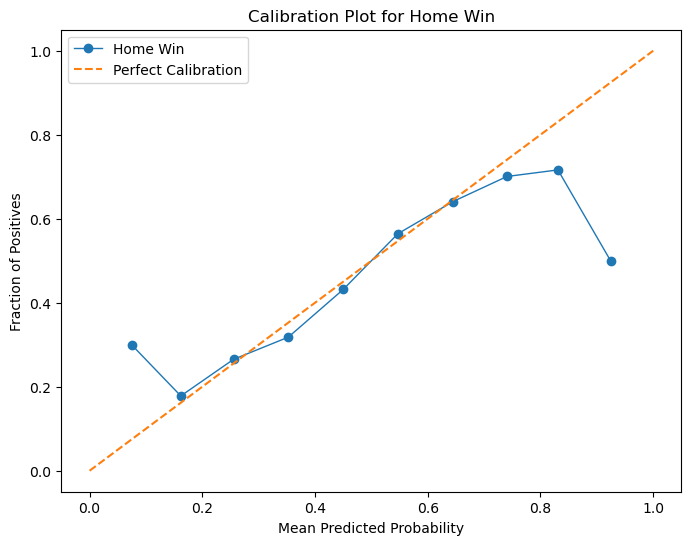

In [28]:
from sklearn.calibration import calibration_curve
%pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

home_win_index = np.where(model.classes_ == 'home_win')[0][0]
prob_true, prob_pred = calibration_curve((y_test == 'home_win').astype(int), 
                                           y_proba[:, home_win_index],
                                           n_bins=10)

plt.figure(figsize=(8,6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Home Win')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot for Home Win')
plt.legend()
plt.show()
#hello

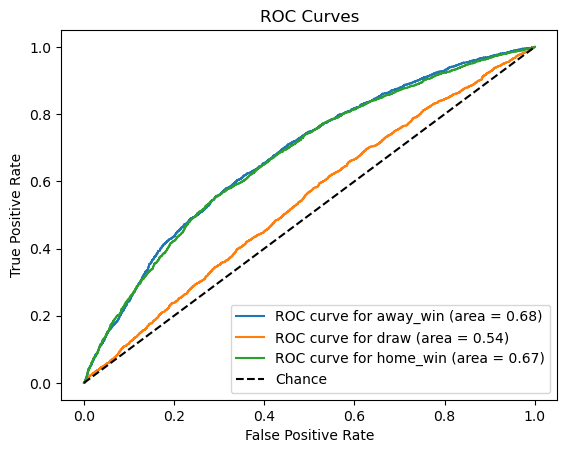

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=model.classes_)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {model.classes_[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()


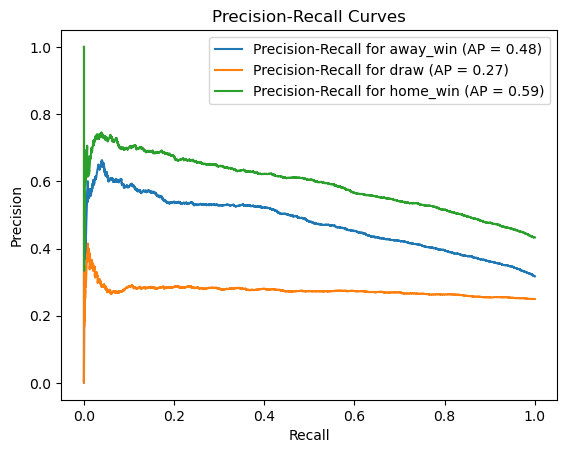

In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f'Precision-Recall for {model.classes_[i]} (AP = {avg_precision:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='best')
plt.show()


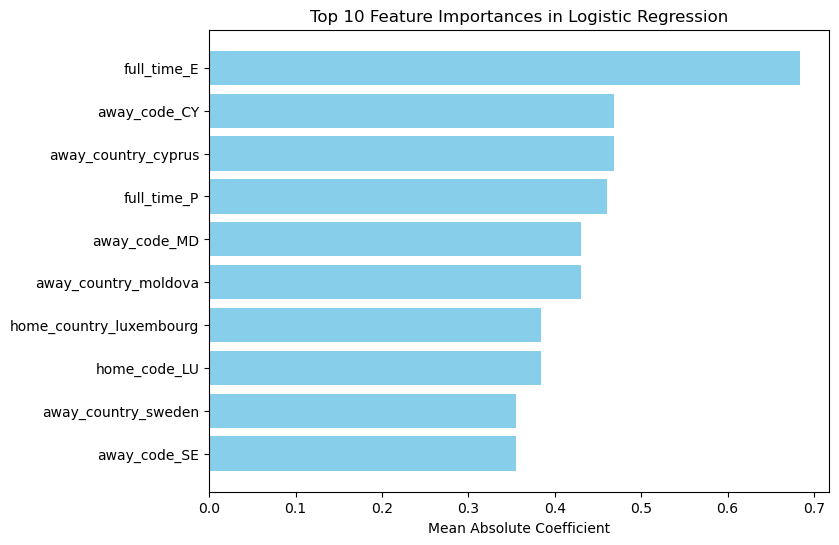

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names from the preprocessor
numeric_features = preprocessor.transformers_[0][2]
categorical_features = preprocessor.transformers_[1][1].get_feature_names_out()
feature_names = np.concatenate([numeric_features, categorical_features])

# For multiclass logistic regression, average the absolute coefficient values across classes.
# If your model is binary, you can simply use model.coef_[0] instead.
mean_abs_coefs = np.mean(np.abs(model.coef_), axis=0)

# Get indices of features sorted in descending order by importance
top_n = 10
top_indices = np.argsort(mean_abs_coefs)[::-1][:top_n]

# Get the top feature names and their mean absolute coefficient values
top_feature_names = np.array(feature_names)[top_indices]
top_coefs = mean_abs_coefs[top_indices]

# Plot the top coefficients in a horizontal bar chart
plt.figure(figsize=(8, 6))
plt.barh(range(top_n), top_coefs, align='center', color='skyblue')
plt.yticks(range(top_n), top_feature_names)
plt.xlabel('Mean Absolute Coefficient')
plt.title('Top 10 Feature Importances in Logistic Regression')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [34]:
# %%
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Initialize the XGBoost classifier for multiclass classification.
# The objective 'multi:softprob' tells XGBoost to output probabilities for each class.
model_xgb = XGBClassifier(objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss')

# Train the model using the preprocessed training data.
model_xgb.fit(X_train_preprocessed, y_train_encoded)

# Make predictions and obtain class probabilities on the test set.
y_pred_xgb = model_xgb.predict(X_test_preprocessed)
y_proba_xgb = model_xgb.predict_proba(X_test_preprocessed)

# Evaluate the performance with a confusion matrix and a classification report.
print("Confusion Matrix for XGBoost:")
print(confusion_matrix(y_test_encoded, y_pred_xgb))
print("\nClassification Report for XGBoost:")
print(classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:58:06] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Confusion Matrix for XGBoost:
[[ 965  265 1205]
 [ 501  218 1196]
 [ 564  347 2410]]

Classification Report for XGBoost:
              precision    recall  f1-score   support

    away_win       0.48      0.40      0.43      2435
        draw       0.26      0.11      0.16      1915
    home_win       0.50      0.73      0.59      3321

    accuracy                           0.47      7671
   macro avg       0.41      0.41      0.39      7671
weighted avg       0.43      0.47      0.43      7671



In [36]:
# %%
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Ensure the cell at index 0 is executed before this cell to define model_xgb, y_test, and y_proba_xgb.

# Check if 'home_win' exists in model_xgb.classes_
if 'home_win' in model_xgb.classes_:
    # Select the index corresponding to the 'home_win' class.
    home_win_index = np.where(model_xgb.classes_ == 'home_win')[0][0]

    # Compute the calibration curve data.
    prob_true, prob_pred = calibration_curve((y_test == 'home_win').astype(int), 
                                               y_proba_xgb[:, home_win_index],
                                               n_bins=10)

    # Plot the calibration curve.
    plt.figure(figsize=(8,6))
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Home Win')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Plot for Home Win (XGBoost)')
    plt.legend()
    plt.show()
else:
    print("'home_win' class not found in model_xgb.classes_")


'home_win' class not found in model_xgb.classes_


In [ ]:
# %%
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the test labels for multiclass ROC analysis.
y_test_bin = label_binarize(y_test, classes=model_xgb.classes_)
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Plot ROC curves for each class.
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_xgb[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {model_xgb.classes_[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (XGBoost)')
plt.legend(loc="lower right")
plt.show()

# %%
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot Precision-Recall curves for each class.
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba_xgb[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_proba_xgb[:, i])
    plt.plot(recall, precision, label=f'Precision-Recall for {model_xgb.classes_[i]} (AP = {avg_precision:0.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (XGBoost)')
plt.legend(loc='best')
plt.show()
